In [8]:
# Installing the necessary liabraries for running the code
!pip install pandas
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install mtcnn
!pip install openai
!pip install anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.8/870.8 kB 5.5 MB/s eta 0:00:00


In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#importing necessary liabraries in order to run the code
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# loading machine learning model for emotion recognition
emotion_model = tf.keras.models.load_model('/content/drive/MyDrive/my_model_latest9.keras')

# loading the ML model for Gender Recognition.
gender_model = tf.keras.models.load_model('/content/drive/MyDrive/best_fine_tuned_gender_model_.keras')

# loading the ML model for Age Recognition.
age_model = tf.keras.models.load_model('/content/drive/MyDrive/best_age_model6_resnet_224_finetuning.keras')

Taking a Picture in colab adapted from: https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw#scrollTo=ilLkpcKanPRb


In [5]:
# importing liabraries to open camera and take a picture
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import cv2
from google.colab.patches import cv2_imshow

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# function to take a photo of User.
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


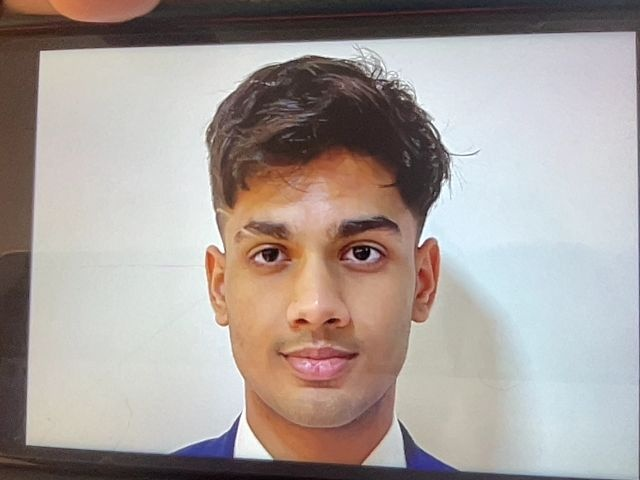

In [28]:
# Try capturing photo of User , if unable, display error.
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Pre-Processing the Image for detecting the face and getting a bounding box

1/1 [==============================] - 0s 240ms/step


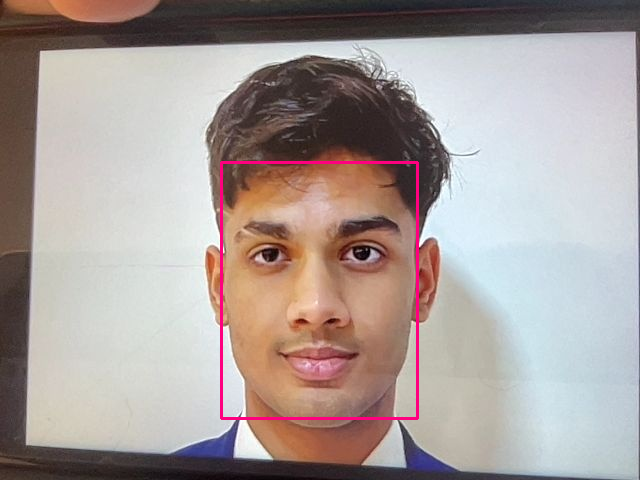

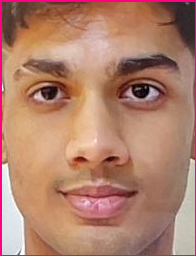

In [29]:
from mtcnn import MTCNN

#Initializing MTCNN model
detector = MTCNN()

#Loading the captured image then converting it to grayscale.
image = cv2.imread('photo.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Detecting the face using MTCNN
faces = detector.detect_faces(image)

# Error handling for when no faces are detected
if len(faces) == 0:
    print("No faces detected")
else:
    # using the first face found
    x, y, w, h = faces[0]['box']

    #cropping the detected region
    face_roi = image[y:y+h, x:x+w]

    #drawing a rectangle on detected image
    cv2.rectangle(image, (x, y), (x+w, y+h), (127, 0, 255), 2)

    #displaying detected face
    cv2_imshow(image)

    #Displaying the cropped face
    cv2_imshow(face_roi)

    # Wait for a key press
    cv2.waitKey(0)

Image Processing for/and Predicting Gender

In [20]:
#Gender REcognition
from tensorflow.keras.applications.resnet import preprocess_input

final_image2 = cv2.resize(face_roi,(224,224))
final_image2 = np.expand_dims(final_image2,axis=0) # need a fourth dimenstion

#final_image2 = final_image2/255.0 # normalizing
#final_image2 = preprocess_input(final_image2)

Gender_Prediction = gender_model.predict(final_image2)

#Printign the Gender Predicted
Predicted_Gender = (np.argmax(Gender_Prediction))
if (Predicted_Gender==0):
  Predicted_Gender = ("Male")
elif (Predicted_Gender==1):
  Predicted_Gender = ("Female")

print(Predicted_Gender)

1/1 [==============================] - 0s 200ms/step
Male


Image Processing for/and Predicting Age

In [22]:
#Age Prediction
import cv2
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np

# Preprocessing
final_image3 = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)  # converting to RGB
final_image3 = cv2.resize(final_image3, (224, 224))
final_image3 = np.expand_dims(final_image3, axis=0)  #adding a 4th dimension
final_image3 = preprocess_input(final_image3)  # Preprocessing input as required by the model

Age_Prediction = age_model.predict(final_image3)
print("Age Prediction:", Age_Prediction)

1/1 [==============================] - 0s 215ms/step
Age Prediction: [[17.824656]]


Image Processing for and Predicting Emotion

In [25]:
#For Emotion detection
final_image4 = cv2.resize(face_roi,(224,224)) #resizing
final_image4 = np.expand_dims(final_image4, axis=0)  #adding a 4th dimension
final_image4 = final_image4/255.0 # normalizing

Predictions = emotion_model.predict(final_image4)

if (np.argmax(Predictions)==0):
  status = "Angry"
elif (np.argmax(Predictions)==1):
  status = "Disgust"
elif (np.argmax(Predictions)==2):
  status = "Fear"
elif (np.argmax(Predictions)==3):
  status = "Happy"
elif (np.argmax(Predictions)==4):
  status = "Sad"
elif (np.argmax(Predictions)==5):
  status = "Surprise"
elif (np.argmax(Predictions)==6):
  status = "Neutral"

print(status)

1/1 [==============================] - 0s 56ms/step
Happy


In [ ]:
import pandas as pd
import os

#initializing csv file or updating if already exists.
def initialize_or_update_csv(user_number, actual_age=None, actual_gender=None, actual_emotion=None, predicted_age=None, predicted_gender=None, predicted_emotion=None, ChatGPT_Recommendation_Rating_1=None, ChatGPT_Recommendation_Rating_2=None, ChatGPT_Recommendation_Rating_3=None, Claude_Recommendation_Rating_1=None, Claude_Recommendation_Rating_2=None, Claude_Recommendation_Rating_3=None,file_path='/content/drive/MyDrive/user_data.csv'):
    #creating pandas DataFrame with the new data
    new_data = pd.DataFrame({
        'User Number': [user_number],
        'Actual Age': [actual_age],
        'Actual Gender': [actual_gender],
        'Actual Emotion': [actual_emotion],
        'Predicted Age': [predicted_age],
        'Predicted Gender': [predicted_gender],
        'Predicted Emotion': [predicted_emotion],
        'ChatGPT Recommendation Rating 1': [ChatGPT_Recommendation_Rating_1],
        'ChatGPT Recommendation Rating 2': [ChatGPT_Recommendation_Rating_2],
        'ChatGPT Recommendation Rating 3': [ChatGPT_Recommendation_Rating_3],
        'Claude Recommendation Rating 1': [Claude_Recommendation_Rating_1],
        'Claude Recommendation Rating 2': [Claude_Recommendation_Rating_2],
        'Claude Recommendation Rating 3': [Claude_Recommendation_Rating_3]
    })

    #Checking if file exists and hence loading or initializing DataFrame
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if user_number in df['User Number'].values:
            df.set_index('User Number', inplace=True)
            new_data.set_index('User Number', inplace=True)
            df.update(new_data)
            df.reset_index(inplace=True)
        else:
            #appending new record
            df = pd.concat([df, new_data], ignore_index=True)
    else:
        # use the new data as the initial data if file doesnt exist
        df = new_data

    #saving the DataFrame back to CSV
    df.to_csv(file_path, index=False)
    print("Data saved successfully.")
    return user_number

#getting the next user number
def get_next_user_number(file_path='/content/drive/MyDrive/user_data.csv'):
    if os.path.exists(file_path):
        df_existing = pd.read_csv(file_path)
        next_user_number = df_existing['User Number'].max() + 1 if not df_existing.empty else 1
        print(f"Next user number generated: {next_user_number}")
        return next_user_number
    else:
        print("File does not exist, starting with user number 1")
        return 1


#prompting user for actual demographic data
actual_age = input("Please enter your actual age: ")
actual_gender = input("Please enter your actual gender (Male or Female): ")
actual_emotion = input("Please enter your actual emotion in the photo:(Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral)")

#storing the predicted values
predicted_gender = Predicted_Gender
predicted_age = Age_Prediction
predicted_emotion = status

#getting the next user number
user_number = get_next_user_number()

# Saving user's demographic data and predicted data to the CSV
user_number = initialize_or_update_csv(user_number, actual_age, actual_gender, actual_emotion, predicted_age, predicted_gender, predicted_emotion)

Please enter your actual age: 20
Please enter your actual gender (Male or Female): Male
Please enter your actual emotion in the photo:(Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral)Happy
Next user number generated: 12
Data saved successfully.


### **Based on Age, Gender and Emotion of the user, we will use API of ChatGPTand Claude  to recommend Movies to Users.**


In [ ]:
# Formatting the user message to pass into the API call
user_content = f"{actual_gender}, {actual_emotion}, {actual_age}"

Movie Recommender Based on Age, Gender and Emotion of User using OpenAI Api

In [ ]:
#from openai import OpenAI
from openai import OpenAI

OpenAI_client = OpenAI(
    api_key="",
)

In [ ]:
completion = OpenAI_client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "you are the backend engine of a recommender system. you will recieve 3 inputs age, gender and emotion in no specific order. Based on this, you will recommend 3 Popular English Movies After 2010 along with a very short summary of it that this user might like. Respond only with these 3 outputs in a numbered list, without any title or any other sort of response, and under no circumstance you will respond with anything other than that, any ill input will be taken care of somewhere else. if any case there is an input that isint age,gender, emotion of user, you will simply not reply."},
    {"role": "user", "content": user_content}
  ]
)

In [ ]:
recommendations = completion.choices[0].message.content

#processing Recommendations
movie_list = recommendations.split('\n')
ChatGPT_ratings = {}

print("Recommended Movies:\n")
for index, movie in enumerate(movie_list, start=1):
    if movie.strip():
        print(movie)
        rating = input(f"How would you rate this recommendation (1-5)? ")
        while not rating.isdigit() or not (1 <= int(rating) <= 5):
            print("Invalid input. Please enter a number between 1 and 5.")
            rating = input(f"How would you rate this recommendation (1-5)? ")
        ChatGPT_ratings[f'ChatGPT_Recommendation_Rating_{index}'] = int(rating)

#Saving the ratings to CSV
initialize_or_update_csv(user_number, actual_age, actual_gender, actual_emotion, predicted_age, predicted_gender, predicted_emotion, **ChatGPT_ratings)
print("Rating Stored Successfully")

Recommended Movies:

1. Inception (2010) - A mind-bending thriller where a thief enters the dreams of others to steal their secrets.
How would you rate this recommendation (1-5)? 5
2. Interstellar (2014) - A sci-fi film about astronauts who travel through a wormhole in search of a new habitable planet for humanity.
How would you rate this recommendation (1-5)? 5
3. The Social Network (2010) - A drama depicting the founding of Facebook and the legal battles that followed.
How would you rate this recommendation (1-5)? 4
Rating Stored Successfully


Movie Recommender Based on Age, Gender and Emotion of User using Anthropic Api

In [ ]:
import anthropic

anthropic_client = anthropic.Anthropic
    api_key="",
)


In [ ]:
message = anthropic_client.messages.create(
    model="claude-3-opus-20240229",
    max_tokens=1000,
    temperature=0,
    system="you are the backend engine of a recommender system. You will receive 3 inputs—age, gender, and emotion—in no specific order. Based on this, you will recommend 3 popular English movies after 2010 along with a very short summary of it that this user might like. Respond only with these 3 outputs in a numbered list, without any title or any other sort of response, and under no circumstance will you respond with anything other than that. If there is any input that isn't age, gender, or emotion of the user, you will simply not reply.",
    messages=[
        {
            "role": "user",
            "content": user_content
        }
    ]
)


In [ ]:
claude_recommendations = message.content

if claude_recommendations and isinstance(claude_recommendations, list):
    Claude_ratings = {}
    print("Recommended Movies from Claude:\n")

    # Assume there's only one TextBlock with all recommendations
    if hasattr(claude_recommendations[0], 'text'):
        # Split the recommendations into individual movies
        movies = claude_recommendations[0].text.strip().split("\n\n")
        # Process each movie recommendation
        for index, movie in enumerate(movies[:3], start=1):  # Limit to the first three recommendations
            print(f"{index}. {movie}")
            rating = input(f"How would you rate this recommendation (1-5)? ")
            while not rating.isdigit() or not (1 <= int(rating) <= 5):
                print("Invalid input. Please enter a number between 1 and 5.")
                rating = input(f"How would you rate this recommendation (1-5)? ")
            Claude_ratings[f'Claude_Recommendation_Rating_{index}'] = int(rating)

    # Ensure only expected keys are in the ratings dictionary
    expected_keys = {'Claude_Recommendation_Rating_1', 'Claude_Recommendation_Rating_2', 'Claude_Recommendation_Rating_3'}
    if not expected_keys.issuperset(Claude_ratings.keys()):
        print("Error: Invalid keys in Claude ratings.")
    else:
        initialize_or_update_csv(user_number, actual_age, actual_gender, actual_emotion, predicted_age, predicted_gender, predicted_emotion, **Claude_ratings)
        print("Rating Stored Successfully")
else:
    print("No recommendations received or incorrect format.")


Recommended Movies from Claude:

1. 1. The Best Exotic Marigold Hotel (2011) - A group of British retirees travel to India to stay at a newly restored hotel, finding renewed purpose and unexpected love in their twilight years.
How would you rate this recommendation (1-5)? 4
2. 2. Mamma Mia! Here We Go Again (2018) - In this sequel to the 2008 musical, Sophie prepares for the grand reopening of her mother's hotel while learning more about Donna's past and the three men who could be her father.
How would you rate this recommendation (1-5)? 3
3. 3. The Hundred-Foot Journey (2014) - An Indian family opens a restaurant in a small French village, sparking a culinary rivalry and an unlikely friendship between the proprietors of the two establishments.
How would you rate this recommendation (1-5)? 4
Data saved successfully.
Rating Stored Successfully
